# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return dist*pen

def sim_anneal_iso():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


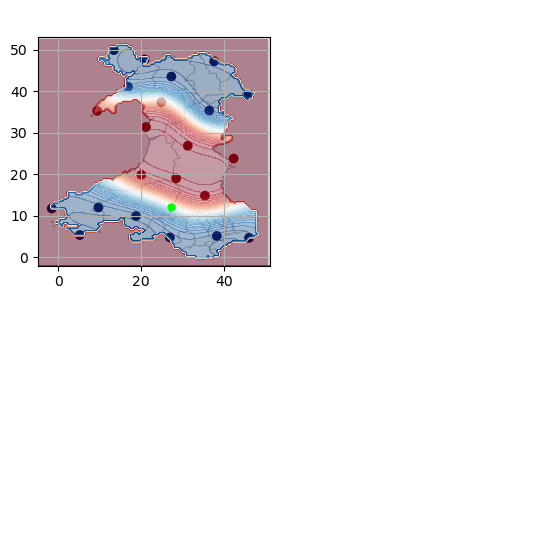

iteration  1
Accuracy is 0.5779657758123438
sim_anneal_isolated coord: (9.682526083174668, 12.031195628625179) distance: [[26.15032902]]
iteration  2
Accuracy is 0.6569890405691213
sim_anneal_isolated coord: (45.96567648523404, 4.688691918608098) distance: [[26.66110084]]
iteration  3
Accuracy is 0.6467986925591233
sim_anneal_isolated coord: (9.385180403782796, 35.29368203563421) distance: [[19.67586672]]
iteration  4
Accuracy is 0.6975581618919439
sim_anneal_isolated coord: (45.79400088171492, 39.33575811001966) distance: [[19.02544899]]
iteration  5
Accuracy is 0.6823687752355316
sim_anneal_isolated coord: (26.88363592188466, 4.799477903793086) distance: [[18.65947269]]
iteration  6
Accuracy is 0.6689098250336474
sim_anneal_isolated coord: (19.977153943830828, 19.862918431950266) distance: [[12.93503942]]
iteration  7
Accuracy is 0.7481253605075947
sim_anneal_isolated coord: (13.386579284950095, 49.917657955043516) distance: [[15.1615258]]
iteration  8
Accuracy is 0.7506248798308017


<IPython.core.display.Javascript object>


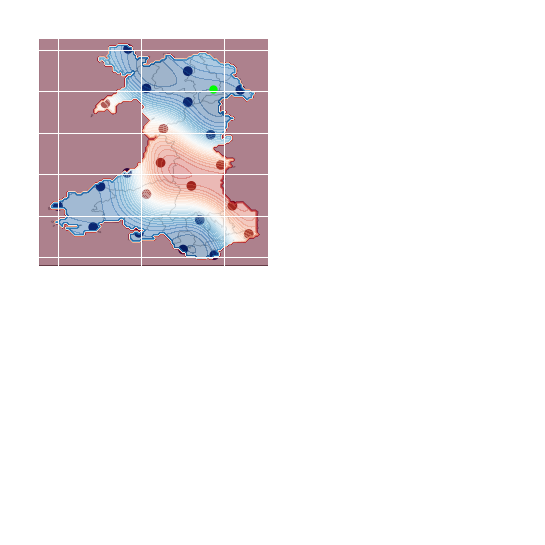

iteration  1
Accuracy is 0.505095174004999
sim_anneal_isolated coord: (16.812499720681842, 50.2068025184678) distance: [[45.36368727]]
iteration  2
Accuracy is 0.634108825225918
sim_anneal_isolated coord: (-0.08294958761454563, 12.362334423533877) distance: [[31.9207783]]
iteration  3
Accuracy is 0.6319938473370506
sim_anneal_isolated coord: (43.87184846214843, 40.360518450969586) distance: [[27.98218407]]
iteration  4
Accuracy is 0.631609305902711
sim_anneal_isolated coord: (25.3108363070191, 30.966693717952147) distance: [[20.80276701]]
iteration  5
Accuracy is 0.7296673716592963
sim_anneal_isolated coord: (21.24603140395795, 15.231779041125623) distance: [[15.99711299]]
iteration  6
Accuracy is 0.7721592001538166
sim_anneal_isolated coord: (11.358450550878429, 37.079765650620935) distance: [[14.21498327]]
iteration  7
Accuracy is 0.7187079407806191
sim_anneal_isolated coord: (36.70472234906072, 29.52895710315466) distance: [[11.48423814]]
iteration  8
Accuracy is 0.7802345702749471


<IPython.core.display.Javascript object>


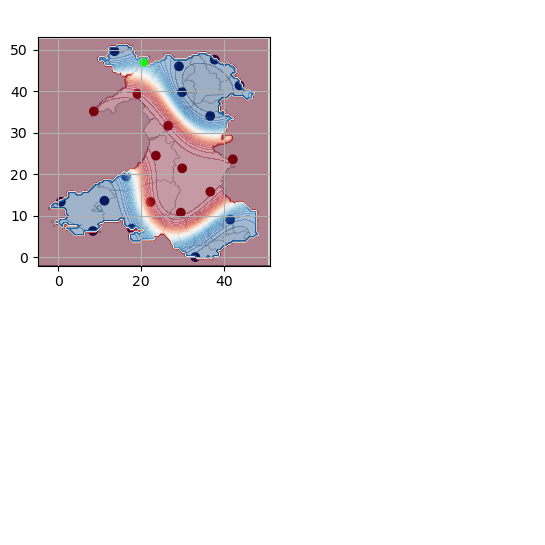

iteration  1
Accuracy is 0.4443376273793501
sim_anneal_isolated coord: (13.543701514665097, 49.642455136128454) distance: [[42.01461437]]
iteration  2
Accuracy is 0.6858296481445876
sim_anneal_isolated coord: (43.648591162781436, 41.41688111246855) distance: [[31.2084035]]
iteration  3
Accuracy is 0.6542972505287444
sim_anneal_isolated coord: (26.47937596688186, 31.714731028102477) distance: [[19.72089417]]
iteration  4
Accuracy is 0.8209959623149394
sim_anneal_isolated coord: (0.6266579373690089, 13.380414066166104) distance: [[28.99543554]]
iteration  5
Accuracy is 0.8106133435877716
sim_anneal_isolated coord: (16.38434920277099, 19.488866642337765) distance: [[15.74915483]]
iteration  6
Accuracy is 0.7152470678715631
sim_anneal_isolated coord: (29.069740010508504, 46.025204630818806) distance: [[14.54302722]]
iteration  7
Accuracy is 0.6942895597000577
sim_anneal_isolated coord: (42.05433948357237, 23.622348945412178) distance: [[14.52672045]]
iteration  8
Accuracy is 0.770813305133

<IPython.core.display.Javascript object>


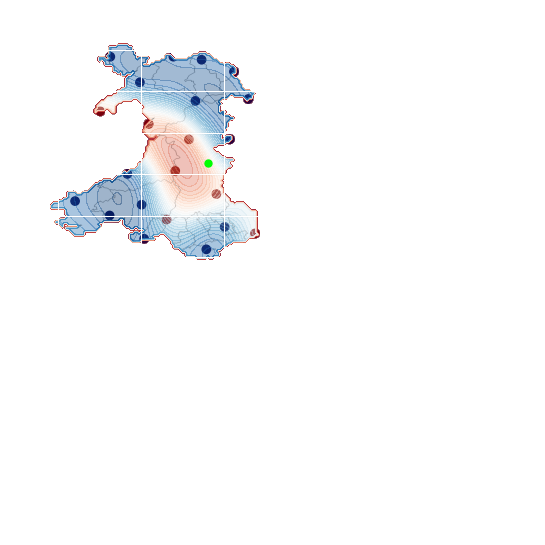

iteration  1
Accuracy is 0.5462411074793309
sim_anneal_isolated coord: (27.72983311477095, 48.336232762151454) distance: [[39.25850817]]
iteration  2
Accuracy is 0.6600653720438378
sim_anneal_isolated coord: (41.34054285221794, 28.45152627458771) distance: [[24.09674193]]
iteration  3
Accuracy is 0.6596808306094982
sim_anneal_isolated coord: (47.37670730741796, 5.762648424292069) distance: [[21.52760551]]
iteration  4
Accuracy is 0.6191117092866757
sim_anneal_isolated coord: (21.79981011799457, 32.12593077339896) distance: [[17.26091143]]
iteration  5
Accuracy is 0.7521630455681599
sim_anneal_isolated coord: (12.53528500223564, 48.328795345905434) distance: [[15.19454993]]
iteration  6
Accuracy is 0.7535089405883484
sim_anneal_isolated coord: (42.31786138583455, 44.74010940743078) distance: [[15.02473534]]
iteration  7
Accuracy is 0.7438954047298596
sim_anneal_isolated coord: (38.082648774451286, 15.250576791633705) distance: [[13.28157779]]
iteration  8
Accuracy is 0.7979234762545664


<IPython.core.display.Javascript object>


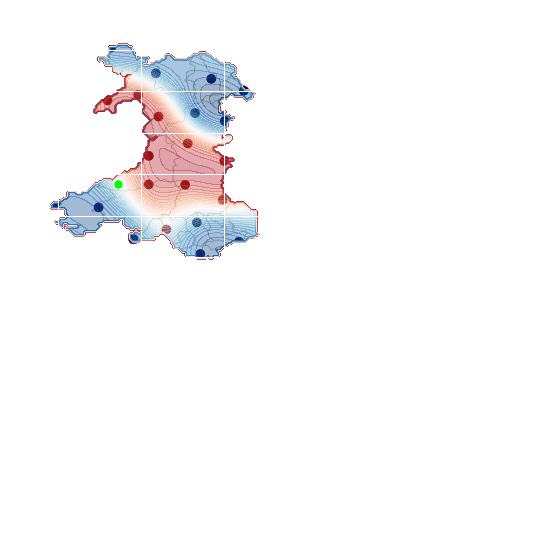

iteration  1
Accuracy is 0.6198807921553547
sim_anneal_isolated coord: (9.73641516634532, 12.05742825813423) distance: [[26.41084043]]
iteration  2
Accuracy is 0.6631417035185542
sim_anneal_isolated coord: (43.529656179172676, 3.7889691535842265) distance: [[26.67493429]]
iteration  3
Accuracy is 0.6477600461449721
sim_anneal_isolated coord: (11.850813822550185, 37.82522044311154) distance: [[21.95972931]]
iteration  4
Accuracy is 0.6985195154777928
sim_anneal_isolated coord: (26.060601037782874, 6.704867599131784) distance: [[17.17931751]]
iteration  5
Accuracy is 0.7279369352047683
sim_anneal_isolated coord: (23.507021536040245, 44.32434422008344) distance: [[13.34562805]]
iteration  6
Accuracy is 0.7848490674870218
sim_anneal_isolated coord: (39.596975898817014, 13.828708707335313) distance: [[10.78250177]]
iteration  7
Accuracy is 0.7537012113055181
sim_anneal_isolated coord: (21.782365451999883, 17.563769189691122) distance: [[11.67129142]]
iteration  8
Accuracy is 0.7119784656796

<IPython.core.display.Javascript object>


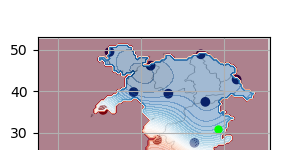

iteration  1
Accuracy is 0.40626802537973467
sim_anneal_isolated coord: (12.356435624319037, 49.48520171935795) distance: [[31.75737879]]
iteration  2
Accuracy is 0.6890982503364738
sim_anneal_isolated coord: (42.95991123111873, 42.84477562681768) distance: [[30.40415092]]
iteration  3
Accuracy is 0.6764083830032686
sim_anneal_isolated coord: (26.509844455247578, 39.42658169749015) distance: [[16.80145073]]
iteration  4
Accuracy is 0.6662180349932705
sim_anneal_isolated coord: (1.5316174077893034, 9.190630120979648) distance: [[24.14254468]]
iteration  5
Accuracy is 0.6558354162661026
sim_anneal_isolated coord: (17.55643313316135, 5.360408546276519) distance: [[15.40975646]]
iteration  6
Accuracy is 0.6402614881753509
sim_anneal_isolated coord: (10.782349707598625, 35.526110648709235) distance: [[14.047561]]
iteration  7
Accuracy is 0.6792924437608152
sim_anneal_isolated coord: (32.79508105183032, 27.596938256035568) distance: [[12.38435253]]
iteration  8
Accuracy is 0.6556431455489329

<IPython.core.display.Javascript object>


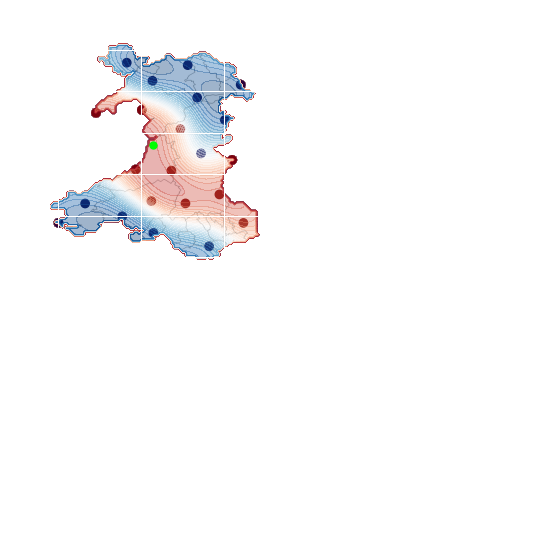

iteration  1
Accuracy is 0.5696981349740434
sim_anneal_isolated coord: (43.93851363087478, 41.58090193392186) distance: [[27.95217256]]
iteration  2
Accuracy is 0.7133243606998654
sim_anneal_isolated coord: (6.47193065005748, 12.975184543665048) distance: [[24.16444608]]
iteration  3
Accuracy is 0.6848682945587387
sim_anneal_isolated coord: (29.419876647929627, 30.90814096238905) distance: [[17.94941097]]
iteration  4
Accuracy is 0.7756200730628725
sim_anneal_isolated coord: (41.88459418483514, 23.461143628260857) distance: [[14.51988129]]
iteration  5
Accuracy is 0.7242837915785426
sim_anneal_isolated coord: (44.59128272226377, 8.297486613303647) distance: [[14.72594273]]
iteration  6
Accuracy is 0.6927513939626995
sim_anneal_isolated coord: (18.660595999443622, 21.140740171251174) distance: [[14.48069989]]
iteration  7
Accuracy is 0.6273793501249759
sim_anneal_isolated coord: (31.183039724937004, 46.303272828731764) distance: [[13.60157717]]
iteration  8
Accuracy is 0.695058642568736

<IPython.core.display.Javascript object>


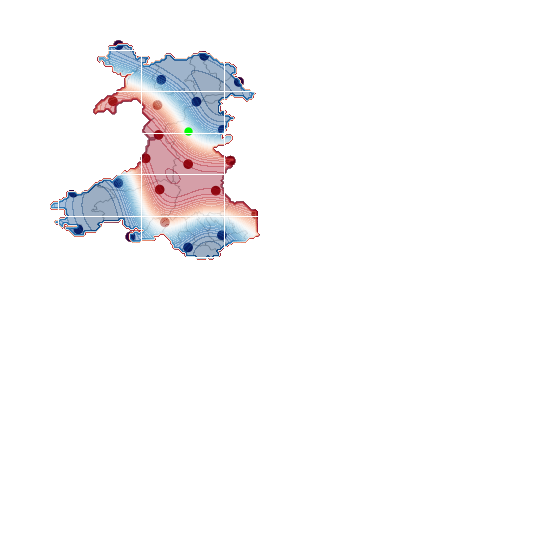

iteration  1
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (13.156566071332106, 37.60544968652111) distance: [[24.06732003]]
iteration  2
Accuracy is 0.4560661411267064
sim_anneal_isolated coord: (47.663218875027304, 10.410216758172666) distance: [[23.99172677]]
iteration  3
Accuracy is 0.4283791578542588
sim_anneal_isolated coord: (3.6515189490075404, 15.581225078498688) distance: [[20.77623955]]
iteration  4
Accuracy is 0.570082676408383
sim_anneal_isolated coord: (39.628229739621396, 30.72775203305609) distance: [[18.37882656]]
iteration  5
Accuracy is 0.687175543164776
sim_anneal_isolated coord: (31.258470691589682, 2.3938708030478866) distance: [[15.52911737]]
iteration  6
Accuracy is 0.7440876754470294
sim_anneal_isolated coord: (24.17601171256157, 29.500121158763395) distance: [[13.16894036]]
iteration  7
Accuracy is 0.771774658719477
sim_anneal_isolated coord: (14.535646963546588, 51.099073638618364) distance: [[13.56391357]]
iteration  8
Accuracy is 0.83926168044606

<IPython.core.display.Javascript object>


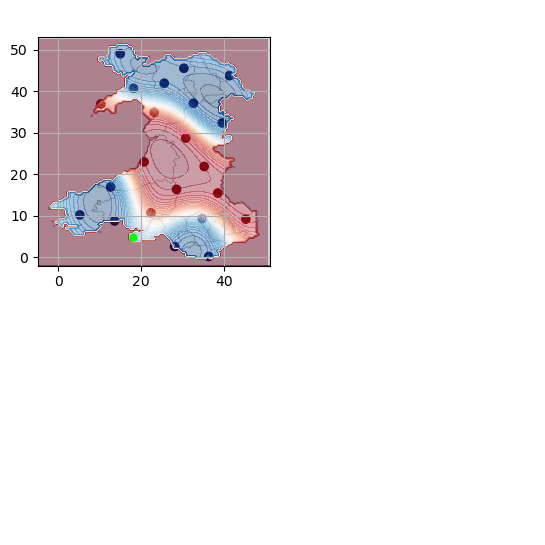

iteration  1
Accuracy is 0.5514324168429148
sim_anneal_isolated coord: (14.922743870229496, 49.050401189552574) distance: [[33.8726988]]
iteration  2
Accuracy is 0.6783310901749664
sim_anneal_isolated coord: (41.21975317205945, 43.780947295781566) distance: [[22.71482365]]
iteration  3
Accuracy is 0.65814266487214
sim_anneal_isolated coord: (36.24377883221504, 0.2137506734696366) distance: [[21.70213604]]
iteration  4
Accuracy is 0.6423764660642184
sim_anneal_isolated coord: (23.144244933631935, 34.96812392622934) distance: [[16.30655122]]
iteration  5
Accuracy is 0.7417804268409921
sim_anneal_isolated coord: (22.303514608457128, 10.729280031970784) distance: [[17.02550098]]
iteration  6
Accuracy is 0.7710055758507979
sim_anneal_isolated coord: (20.65599459292945, 22.99296810293411) distance: [[12.23093401]]
iteration  7
Accuracy is 0.7377427417804269
sim_anneal_isolated coord: (10.269629533538993, 36.95327053719535) distance: [[12.96117445]]
iteration  8
Accuracy is 0.7217842722553355

<IPython.core.display.Javascript object>


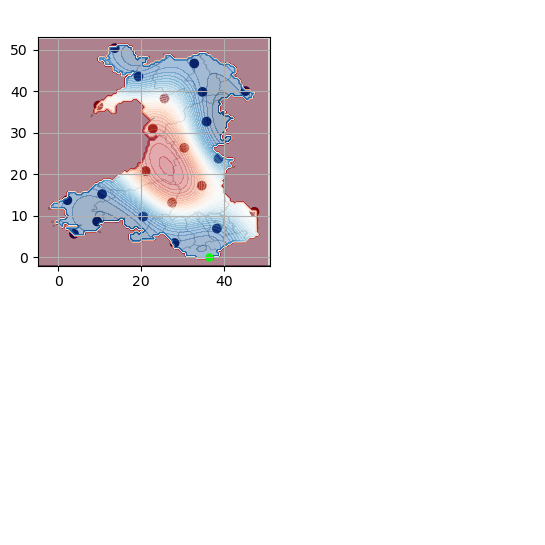

iteration  1
Accuracy is 0.5945010574889444
sim_anneal_isolated coord: (47.24672070483541, 10.977497195453648) distance: [[27.99778145]]
iteration  2
Accuracy is 0.46029609690444145
sim_anneal_isolated coord: (35.7352740438671, 32.68381195554791) distance: [[18.92846946]]
iteration  3
Accuracy is 0.6029609690444145
sim_anneal_isolated coord: (3.794123593525673, 5.678181995623474) distance: [[22.90710845]]
iteration  4
Accuracy is 0.6904441453566622
sim_anneal_isolated coord: (28.02221328718714, 3.4597158136886748) distance: [[18.68002818]]
iteration  5
Accuracy is 0.6875600845991156
sim_anneal_isolated coord: (32.752748070331485, 46.69534348490489) distance: [[13.7916693]]
iteration  6
Accuracy is 0.6869832724476063
sim_anneal_isolated coord: (34.584114217174125, 17.28742402143724) distance: [[14.00579425]]
iteration  7
Accuracy is 0.7679292443760816
sim_anneal_isolated coord: (10.558211045252111, 15.245613782412983) distance: [[11.71702309]]
iteration  8
Accuracy is 0.7848490674870218

<IPython.core.display.Javascript object>


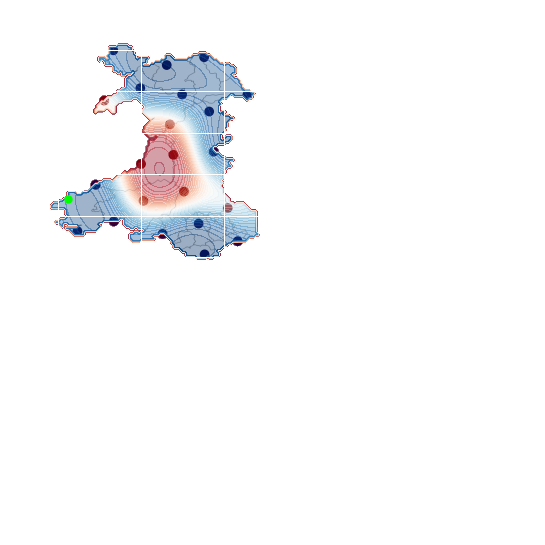

iteration  1
Accuracy is 0.5612382234185733
sim_anneal_isolated coord: (26.127204466157373, 46.32324925133803) distance: [[37.43727967]]
iteration  2
Accuracy is 0.6173812728321476
sim_anneal_isolated coord: (19.940375747244023, 22.49784378085565) distance: [[22.27381703]]
iteration  3
Accuracy is 0.7237069794270332
sim_anneal_isolated coord: (45.537007996151694, 39.112227053754616) distance: [[20.70602121]]
iteration  4
Accuracy is 0.7588925206691021
sim_anneal_isolated coord: (11.079111777765121, 37.75199290311334) distance: [[17.31795395]]
iteration  5
Accuracy is 0.7415881561238223
sim_anneal_isolated coord: (25.11352212654151, 5.6587313661705885) distance: [[16.89529963]]
iteration  6
Accuracy is 0.7552393770428764
sim_anneal_isolated coord: (37.427970250262504, 25.453479495165848) distance: [[13.98183212]]
iteration  7
Accuracy is 0.6592962891751586
sim_anneal_isolated coord: (26.90078420401339, 32.04280705854615) distance: [[11.81328108]]
iteration  8
Accuracy is 0.7233224379926

<IPython.core.display.Javascript object>


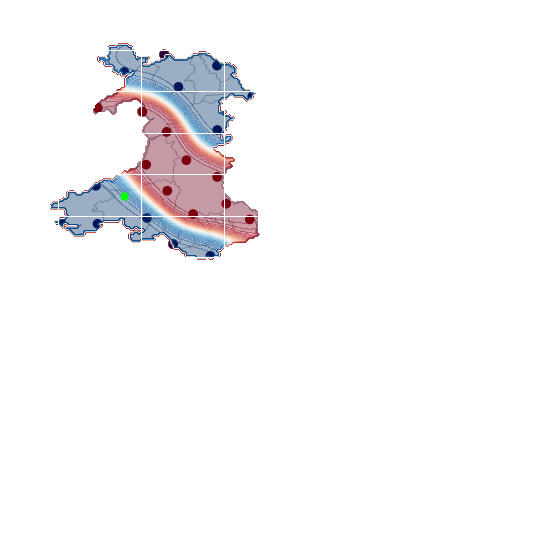

iteration  1
Accuracy is 0.48202268794462605
sim_anneal_isolated coord: (36.64639738095858, 0.36177501184553584) distance: [[31.66446783]]
iteration  2
Accuracy is 0.6942895597000577
sim_anneal_isolated coord: (0.6233048016747931, 8.47302794997243) distance: [[33.50605413]]
iteration  3
Accuracy is 0.6833301288213806
sim_anneal_isolated coord: (46.74045798548357, 38.78267057848956) distance: [[22.33497841]]
iteration  4
Accuracy is 0.6714093443568544
sim_anneal_isolated coord: (21.368206111621852, 9.49726559101145) distance: [[17.80113245]]
iteration  5
Accuracy is 0.6600653720438378
sim_anneal_isolated coord: (28.93128720561102, 41.0678373582597) distance: [[11.20628313]]
iteration  6
Accuracy is 0.6206498750240338
sim_anneal_isolated coord: (38.28118560752804, 19.3827370147404) distance: [[16.29739687]]
iteration  7
Accuracy is 0.7187079407806191
sim_anneal_isolated coord: (9.045611642257217, 17.239675081740494) distance: [[12.1568645]]
iteration  8
Accuracy is 0.7140934435685445
sim

<IPython.core.display.Javascript object>


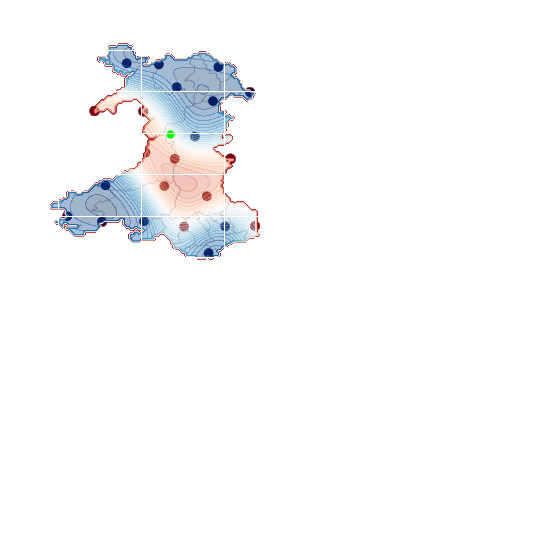

iteration  1
Accuracy is 0.5556623726206499
sim_anneal_isolated coord: (36.21429904117363, 1.0422255030580505) distance: [[28.26399804]]
iteration  2
Accuracy is 0.645260526821765
sim_anneal_isolated coord: (16.506201309525167, 46.76006130954928) distance: [[22.00578917]]
iteration  3
Accuracy is 0.6325706594885598
sim_anneal_isolated coord: (2.175760724893637, 9.9068328462113) distance: [[24.28320648]]
iteration  4
Accuracy is 0.6264179965391271
sim_anneal_isolated coord: (8.730578354493275, 35.269752786027325) distance: [[13.87398653]]
iteration  5
Accuracy is 0.6608344549125168
sim_anneal_isolated coord: (38.56495407629584, 45.85834562363689) distance: [[17.67973472]]
iteration  6
Accuracy is 0.6554508748317631
sim_anneal_isolated coord: (20.645961233147528, 8.706586159238427) distance: [[16.51987479]]
iteration  7
Accuracy is 0.6446837146702558
sim_anneal_isolated coord: (35.79388421547967, 14.731202993733191) distance: [[13.69543184]]
iteration  8
Accuracy is 0.6962122668717554
si

<IPython.core.display.Javascript object>


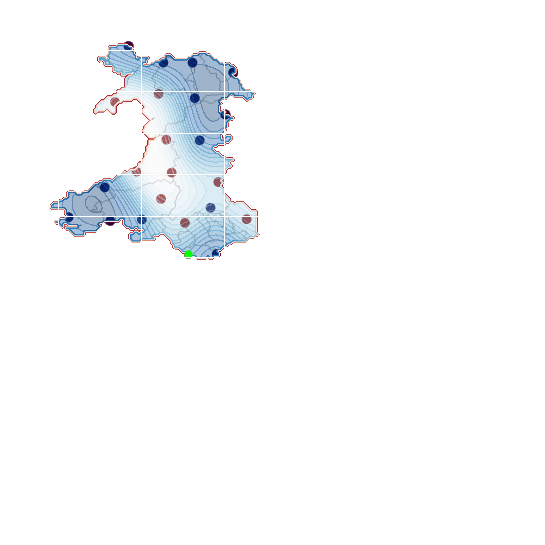

iteration  1
Accuracy is 0.5716208421457412
sim_anneal_isolated coord: (25.999727050581093, 28.349733102395213) distance: [[15.32377611]]
iteration  2
Accuracy is 0.47240915208613726
sim_anneal_isolated coord: (2.4954908447927346, 9.664869447338734) distance: [[29.94160766]]
iteration  3
Accuracy is 0.7458181119015574
sim_anneal_isolated coord: (38.16729306665762, 0.8289311791407972) distance: [[30.09059988]]
iteration  4
Accuracy is 0.7283214766391078
sim_anneal_isolated coord: (20.152054003242917, 9.120336953830789) distance: [[17.66495792]]
iteration  5
Accuracy is 0.7256296865987311
sim_anneal_isolated coord: (40.2224096921848, 34.38048046692416) distance: [[14.78843595]]
iteration  6
Accuracy is 0.7206306479523169
sim_anneal_isolated coord: (38.55321578052241, 18.13617302819373) distance: [[16.18353758]]
iteration  7
Accuracy is 0.7886944818304172
sim_anneal_isolated coord: (16.911388930611245, 50.8521408221872) distance: [[13.79473045]]
iteration  8
Accuracy is 0.7969621226687176

<IPython.core.display.Javascript object>


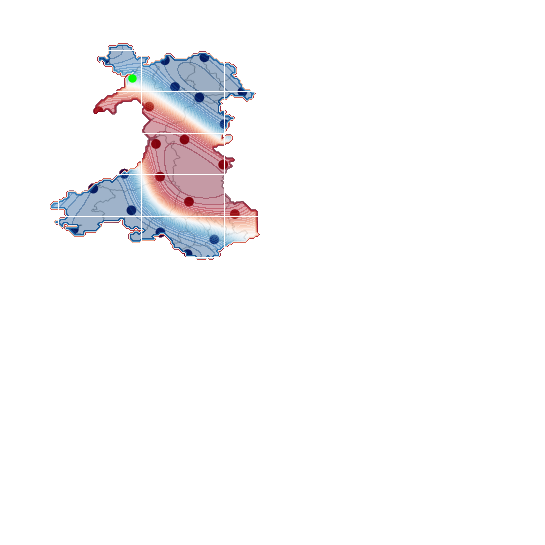

iteration  1
Accuracy is 0.4226110363391655
sim_anneal_isolated coord: (44.35545459477339, 39.89731108293839) distance: [[34.9623654]]
iteration  2
Accuracy is 0.6216112286098827
sim_anneal_isolated coord: (42.53005988668055, 10.421806356345666) distance: [[24.92047345]]
iteration  3
Accuracy is 0.6012305325898866
sim_anneal_isolated coord: (30.408867809380524, 28.369578775343076) distance: [[18.09408453]]
iteration  4
Accuracy is 0.5216304556815997
sim_anneal_isolated coord: (25.678438634752062, 47.4724766379881) distance: [[19.67987975]]
iteration  5
Accuracy is 0.7006344933666603
sim_anneal_isolated coord: (31.141545126296794, 0.7913507729535123) distance: [[14.91455474]]
iteration  6
Accuracy is 0.7281292059219381
sim_anneal_isolated coord: (3.7387778489876835, 6.740751948746638) distance: [[14.62716772]]
iteration  7
Accuracy is 0.7219765429725052
sim_anneal_isolated coord: (11.210234174288223, 47.7353648217309) distance: [[12.60310519]]
iteration  8
Accuracy is 0.7104402999423188

<IPython.core.display.Javascript object>


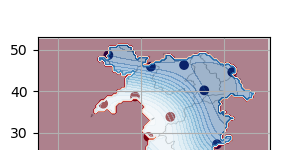

iteration  1
Accuracy is 0.6021918861757354
sim_anneal_isolated coord: (1.286741475532125, 13.188024642488266) distance: [[31.64681153]]
iteration  2
Accuracy is 0.706018073447414
sim_anneal_isolated coord: (10.824181870682096, 37.00935569063961) distance: [[24.54858994]]
iteration  3
Accuracy is 0.7052489905787349
sim_anneal_isolated coord: (19.69471601514825, 3.9273164673591765) distance: [[17.02017972]]
iteration  4
Accuracy is 0.7012113055181696
sim_anneal_isolated coord: (47.54186093864414, 5.83730600699416) distance: [[17.09886739]]
iteration  5
Accuracy is 0.7340895981542012
sim_anneal_isolated coord: (16.259022811003607, 20.28072222042208) distance: [[16.56730417]]
iteration  6
Accuracy is 0.6566044991347818
sim_anneal_isolated coord: (22.30812052153844, 45.9254793077312) distance: [[14.06198883]]
iteration  7
Accuracy is 0.6785233608921362
sim_anneal_isolated coord: (38.25122735205592, 27.25560168902054) distance: [[13.32962552]]
iteration  8
Accuracy is 0.6548740626802538
sim

<IPython.core.display.Javascript object>


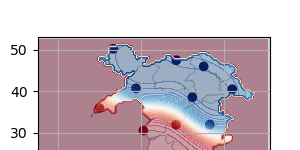

iteration  1
Accuracy is 0.500865218227264
sim_anneal_isolated coord: (41.90412577831041, 40.48791933124949) distance: [[29.97309429]]
iteration  2
Accuracy is 0.6587194770236493
sim_anneal_isolated coord: (46.574046839928194, 4.961443722550643) distance: [[31.50814694]]
iteration  3
Accuracy is 0.6423764660642184
sim_anneal_isolated coord: (41.414469172527276, 23.392507137364333) distance: [[17.10242327]]
iteration  4
Accuracy is 0.7400499903864641
sim_anneal_isolated coord: (13.217802381300814, 50.24635095047988) distance: [[30.09440203]]
iteration  5
Accuracy is 0.6927513939626995
sim_anneal_isolated coord: (28.393129593087064, 31.980290634095606) distance: [[14.41385812]]
iteration  6
Accuracy is 0.7617765814266487
sim_anneal_isolated coord: (28.750566177052413, 4.265867886127415) distance: [[17.83704821]]
iteration  7
Accuracy is 0.7383195539319362
sim_anneal_isolated coord: (18.01511648658849, 8.094499554530305) distance: [[11.39773225]]
iteration  8
Accuracy is 0.733897327437031

<IPython.core.display.Javascript object>


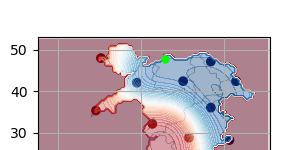

iteration  1
Accuracy is 0.49701980388386846
sim_anneal_isolated coord: (6.708400181029797, 6.6802934777318566) distance: [[41.47315485]]
iteration  2
Accuracy is 0.588925206691021
sim_anneal_isolated coord: (43.83984840853461, 6.455556100252417) distance: [[37.13212833]]
iteration  3
Accuracy is 0.5971928475293213
sim_anneal_isolated coord: (25.121598004396336, 20.15786636694717) distance: [[22.81865082]]
iteration  4
Accuracy is 0.7448567583157085
sim_anneal_isolated coord: (27.766310826369093, 4.195245208165414) distance: [[16.18022806]]
iteration  5
Accuracy is 0.7019803883868487
sim_anneal_isolated coord: (41.2224975308102, 28.261192854867254) distance: [[18.02506216]]
iteration  6
Accuracy is 0.6796769851951547
sim_anneal_isolated coord: (9.087789531025308, 35.368174115938444) distance: [[12.68728111]]
iteration  7
Accuracy is 0.6940972889828879
sim_anneal_isolated coord: (42.82372286274446, 42.439395029972964) distance: [[12.75301654]]
iteration  8
Accuracy is 0.690636416073832


<IPython.core.display.Javascript object>


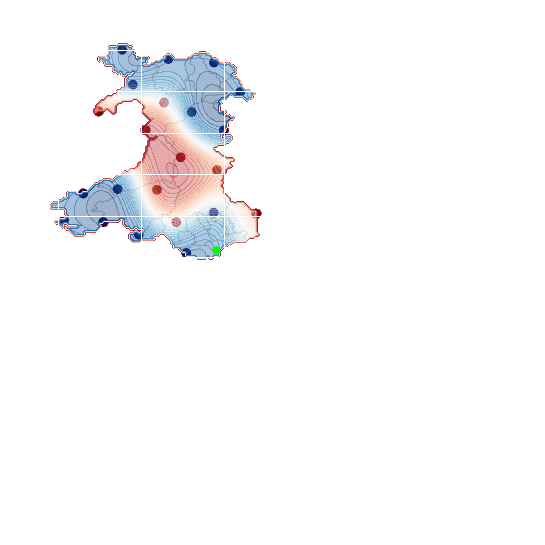

iteration  1
Accuracy is 0.39030955585464333
sim_anneal_isolated coord: (1.40034719282778, 8.970262606287651) distance: [[31.92365326]]
iteration  2
Accuracy is 0.7023649298211883
sim_anneal_isolated coord: (15.392924200367428, 50.01059465251042) distance: [[29.49466702]]
iteration  3
Accuracy is 0.6804460680638339
sim_anneal_isolated coord: (37.5113756123308, 46.93798858772487) distance: [[22.33084864]]
iteration  4
Accuracy is 0.6656412228417612
sim_anneal_isolated coord: (25.467757617746003, 37.27272037918507) distance: [[13.76690614]]
iteration  5
Accuracy is 0.7031340126898673
sim_anneal_isolated coord: (19.388858492370176, 5.447634104906223) distance: [[18.33017868]]
iteration  6
Accuracy is 0.7037108248413767
sim_anneal_isolated coord: (14.280871960295714, 16.445949673790494) distance: [[12.12660182]]
iteration  7
Accuracy is 0.7000576812151509
sim_anneal_isolated coord: (9.733353571686514, 35.207050074122) distance: [[15.8485227]]
iteration  8
Accuracy is 0.6873678138819458
sim

<IPython.core.display.Javascript object>


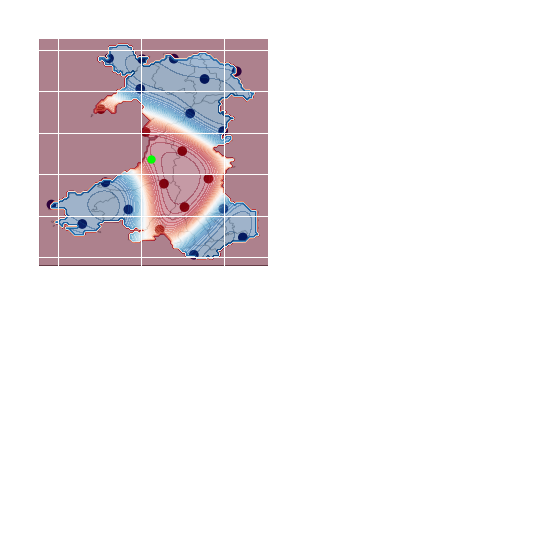

iteration  1
Accuracy is 0.5673908863680062
sim_anneal_isolated coord: (44.46487206382651, 4.804634320289415) distance: [[32.44934216]]
iteration  2
Accuracy is 0.6312247644683715
sim_anneal_isolated coord: (5.773780301083209, 8.042639317725943) distance: [[26.91444323]]
iteration  3
Accuracy is 0.6223803114785618
sim_anneal_isolated coord: (12.220195947137213, 47.96635465494956) distance: [[19.80642279]]
iteration  4
Accuracy is 0.6187271678523361
sim_anneal_isolated coord: (24.41190253242892, 6.665504916012969) distance: [[18.68892986]]
iteration  5
Accuracy is 0.6562199577004422
sim_anneal_isolated coord: (36.17225793567923, 18.97013510694639) distance: [[16.30280569]]
iteration  6
Accuracy is 0.7892712939819265
sim_anneal_isolated coord: (25.458604210146156, 17.740511844337885) distance: [[10.78398579]]
iteration  7
Accuracy is 0.7688905979619304
sim_anneal_isolated coord: (42.991388421005595, 44.813157121196966) distance: [[15.1301994]]
iteration  8
Accuracy is 0.7736973658911748


<IPython.core.display.Javascript object>


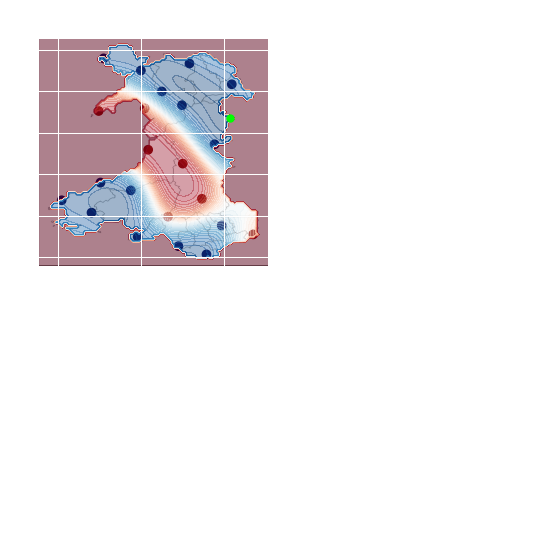

iteration  1
Accuracy is 0.5654681791963084
sim_anneal_isolated coord: (19.903072578338545, 45.00343341603683) distance: [[34.20842742]]
iteration  2
Accuracy is 0.6792924437608152
sim_anneal_isolated coord: (41.79235795476384, 41.69439675877712) distance: [[22.13798857]]
iteration  3
Accuracy is 0.6579503941549703
sim_anneal_isolated coord: (21.656459676435553, 25.926140123998376) distance: [[17.52214473]]
iteration  4
Accuracy is 0.8234954816381466
sim_anneal_isolated coord: (26.436493578857537, 9.804345828348069) distance: [[9.22632618]]
iteration  5
Accuracy is 0.7636992885983465
sim_anneal_isolated coord: (9.730261569509212, 35.2585450842711) distance: [[14.08719037]]
iteration  6
Accuracy is 0.7575466256489136
sim_anneal_isolated coord: (37.65425626737982, 27.238894391060178) distance: [[13.47931337]]
iteration  7
Accuracy is 0.7652374543357047
sim_anneal_isolated coord: (35.698084508803866, 0.7298430494236712) distance: [[12.96625109]]
iteration  8
Accuracy is 0.8040761392039992

In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_iso()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [11]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 86.52 %
Improvement is = 29.98 %


In [13]:
np.savetxt('braninIsolatedSimAnnealrbf', Results)